In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from datetime import date, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import datetime
from datetime import date, timedelta

<h1>Load dataset</h1>

In [2]:
df = pd.read_csv('dataset/new_feature_dataset.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['last_active'] = df['last_active'].apply(lambda x: int(x.split(" ")[0]))
df['player_age'] = df['player_age'].apply(lambda x: int(x.split(" ")[0]))
df['time_since_registration'] = df['time_since_registration'].apply(lambda x: int(x.split(" ")[0]))
df

,player_id,date,bo_count,casino_count,pp_count,sport_count,vb_count,vdr_count,frequency,monetary_value,profit,deposit,last_active,player_age,time_since_registration,is_opt_out,churn
0,2,2022-05-01,1.0,0.0,1.0,13.0,0.0,0.0,2,38.01,-1.809998,1.81,22,10168,2777,0,0
1,4,2022-05-01,11.0,16992.0,79.0,25.0,6153.0,0.0,167,2495.42,-258.329960,257.43,2,18747,2777,0,0
2,5,2022-05-01,2.0,19796.0,43.0,0.0,0.0,0.0,28,7263.29,-411.770020,592.31,6,15087,2777,0,0
3,8,2022-05-01,0.0,0.0,1.0,8.0,0.0,0.0,7,4.91,-1.630000,0.90,1,18619,2776,0,0
4,11,2022-05-01,1.0,0.0,0.0,0.0,0.0,0.0,0,0.00,4.520000,0.00,23,9963,2776,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809655,30926,2022-11-30,0.0,0.0,1.0,11.0,0.0,0.0,4,156.36,47.780000,0.00,1,11952,2,0,0
1809656,30927,2022-11-30,0.0,45.0,1.0,0.0,0.0,0.0,2,1.67,-1.130000,1.13,2,6664,2,0,0
1809657,30929,2022-11-30,0.0,0.0,0.0,2.0,0.0,0.0,0,0.00,-1.000000,0.00,2,7610,2,0,1
1809658,30931,2022-11-30,0.0,0.0,3.0,0.0,19.0,0.0,2,3.67,-2.990000,2.99,1,12095,2,0,0


<h1>Split the data into training and test sets</h1>

In [3]:
def split_df_by_date(df, date_col, date):
    df_before = df[df[date_col] < date]
    df_after = df[df[date_col] >= date]
    return df_before, df_after

In [4]:
df_train, df_test = split_df_by_date(df, 'date', '2022-10-30')

In [5]:
X_train = df_train[['bo_count', 'casino_count', 'pp_count', 'sport_count', 'vb_count', 'vdr_count',
                  'frequency', 'monetary_value', 'profit', 'deposit', 'last_active', 'player_age',
                  'time_since_registration', 'is_opt_out']]
X_test = df_test[['bo_count', 'casino_count', 'pp_count', 'sport_count', 'vb_count', 'vdr_count',
                  'frequency', 'monetary_value', 'profit', 'deposit', 'last_active', 'player_age',
                  'time_since_registration', 'is_opt_out']]

y_train = df_train[['churn']].values.ravel()
y_test = df_test[['churn']].values.ravel()

smote = SMOTE(sampling_strategy = "minority")

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

<h1>Logistic Regression</h1>

In [6]:
clf = LogisticRegression(penalty = None, random_state = 42, max_iter = 10000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000, penalty=None, random_state=42)

<h2>Optimal threshold</h2><br>
Ovdje smo optimizirali tako da zahtijevamo da barem 85% pravih churnera naš model detektira kao churnere, a u isto vrijeme minimiziramo našu metriku koja nam govori koliko smo ukupno igrača detektirali kao churnere. Recimo da šaljemo bonuse svim igračima koje model detektira kao churnere. Ovisno o tome koliko profita nam donosi ispravno detektiranje churnera i koliki je gubitak ako non-churnera detektiramo kao churnera ili churnera kao non-churnera mijenjali bismo fiksni postotak koji je ovdje 85%.

In [7]:
#thresholds = np.arange(0, 1.05, 0.01)
thresholds = np.arange(0.13, 0.15, 0.0001)

metrics = []

for threshold in thresholds:
    
    y_pred = (clf.predict_proba(X_test)[:,1] >= threshold)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    custom_metric = (tp + fp) / (tp + fp + tn + fn)
    rec = tp / (tp + fn)
    
    if(rec > 0.85):
        metrics.append(custom_metric)
    else:
        metrics.append(2.0)
        
best_threshold = thresholds[np.argmin(metrics)]
best_custom_metric = np.min(metrics)

y_pred = (clf.predict_proba(X_test)[:,1] >= best_threshold)

print("Best threshold:", best_threshold)
print("Best custom metric:", best_custom_metric)

Best threshold: 0.1462999999999982
Best custom metric: 0.3449704307074314


<h2>Calculate important metrics</h2>

In [8]:
# calculate accuracy
accuracy = clf.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))

# calculate precision
precision = precision_score(y_test, y_pred)
print("Precision: ", precision)

# calculate recall
recall = recall_score(y_test, y_pred)
print("Recall: ", recall)

# calculate f1-score
f1 = f1_score(y_test, y_pred)
print("F1-Score: ", f1)

# calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred)
print("AUC-ROC: ", auc_roc)

Accuracy: 87.96%
Precision:  0.2951219019124247
Recall:  0.8500101895251682
F1-Score:  0.43812696483369723
AUC-ROC:  0.786880429007043


<h2>Confusion matrix</h2>

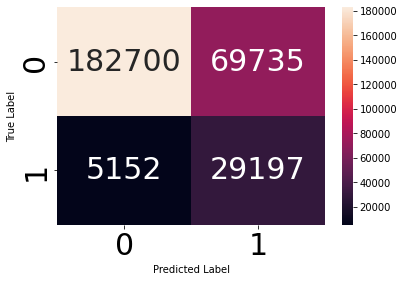

In [9]:
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 30})

plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)


plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

<h2>Correlation matrix</h2>

/tmp/ipykernel_53087/3088594876.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5, annot_kws = {"size": 20})


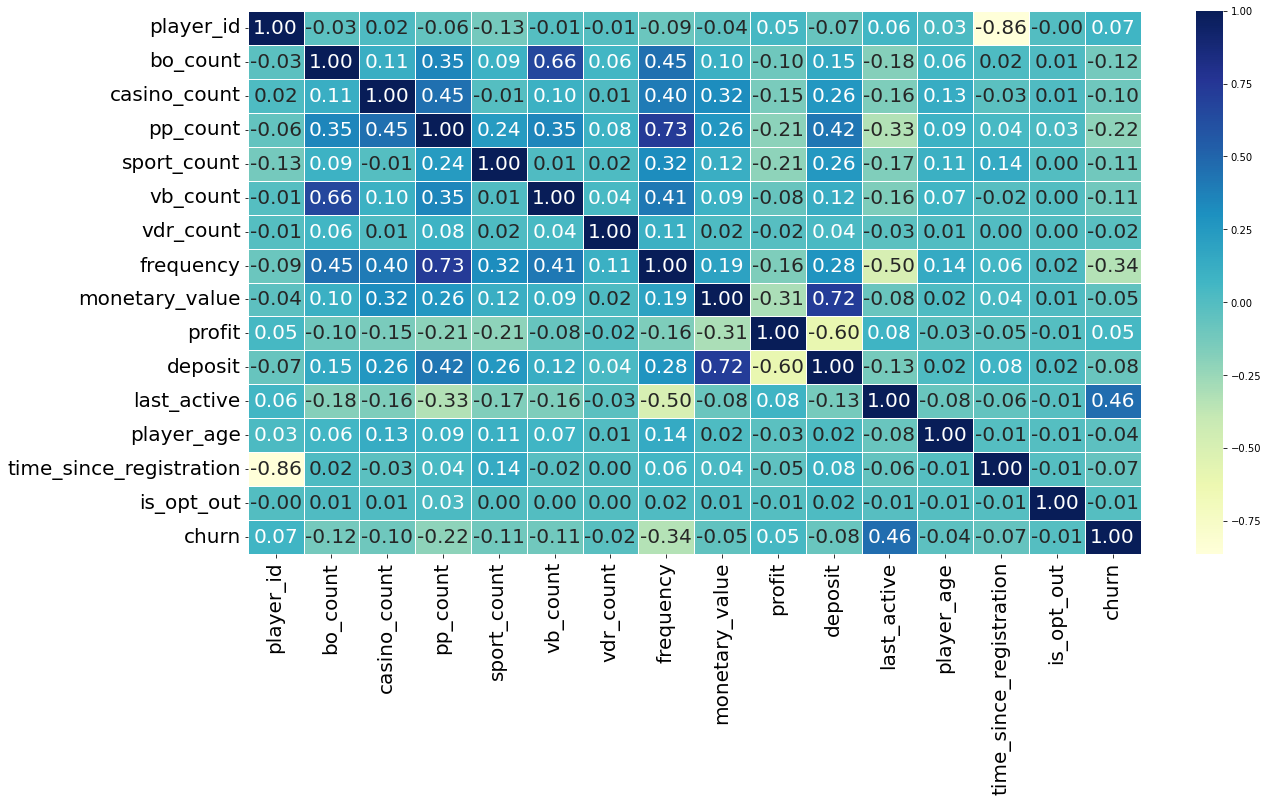

In [10]:
# Adjust the size of the figure
plt.figure(figsize = (20, 10))

# Create the heatmap with larger annotations
sns.heatmap(df.corr(), annot = True, fmt = ".2f", cmap = "YlGnBu", linewidths=.5, annot_kws = {"size": 20})

# Increase the font size of the labels on the x and y axes
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# Show the plot
plt.show()